<a href="https://colab.research.google.com/github/Alg0r1thmic/IA-Topics/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# root path
PATH="/content/drive/My Drive/FlowersData"
INPUTPATH=PATH+ '/inputFlowers'
OUTPATH=PATH+'/targetFlowers'
CKPATH=PATH+'/checkpoints'

imgurls=!ls -1 "{INPUTPATH}"
n=500
train_n=round(n*0.80)

randurls=np.copy(imgurls)

np.random.seed(23)
np.random.shuffle(randurls)

tr_urls=randurls[:train_n]
ts_urls=randurls[train_n:n]
print(len(imgurls),len(tr_urls),len(ts_urls))

7728 400 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


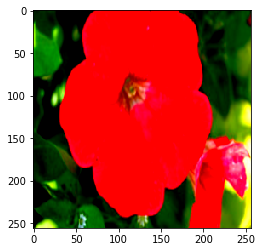

In [0]:
IMG_WIDTH=256
IMG_HEIGHT=256
# rescale image
def resize(inimg,tgimg,height,width):
  inimg=tf.image.resize(inimg,[height,width])
  tgimg=tf.image.resize(tgimg,[height,width])
  return inimg,tgimg
# normalize the image to range -1,1
def normalize(inimg,tgimg):
  inimg=(inimg/127.5)-1
  tgimg=(tgimg/127.5)-1
  return inimg,tgimg
#data augmentation :Random crop + flip
@tf.function()
def random_jitter(inimg,tgimg):
  inimg,tgimg=resize(inimg,tgimg,286,286)
  
  stacked_image=tf.stack([inimg,tgimg],axis=0)
  cropped_image=tf.image.random_crop(stacked_image,size=[2,IMG_HEIGHT,IMG_WIDTH,3])
  inimg,tgimg=cropped_image[0],cropped_image[1]
  if tf.random.uniform(())>0.5:
    inimg=tf.image.flip_left_right(inimg)
    tgimg=tf.image.flip_left_right(tgimg)
  return inimg,tgimg
def load_image(filename,augment=True):
  inimg=tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPUTPATH+'/'+filename)),tf.float32)[..., :3]
  tgimg=tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH+'/'+filename)),tf.float32)[..., :3]
  inimg,tgimg=resize(inimg,tgimg,IMG_HEIGHT,IMG_WIDTH)
  if augment:
    inimg,tgimg=random_jitter(inimg,tgimg)
  inimg,tgimg=normalize(inimg,tgimg)
  return inimg,tgimg
def load_train_image(filename):
  return load_image(filename,True)
def load_test_image(filename):
  return load_image(filename,False)

plt.imshow((load_train_image(randurls[0])[1])+1/2)


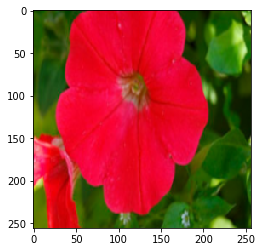

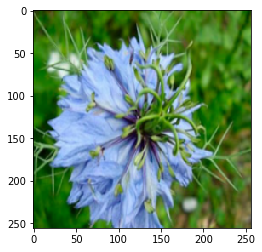

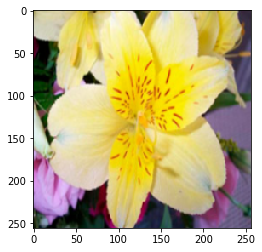

In [0]:
train_dataset=tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset=train_dataset.map(load_train_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset=train_dataset.batch(1)

test_dataset=tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset=test_dataset.map(load_test_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset=test_dataset.batch(1)
for inimg,tgimg in train_dataset.take(3):
  plt.imshow(((tgimg[0,...])+1)/2)
  plt.show()

In [0]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
def downsample(filters,apply_batchnorm=True):
  result=Sequential()
  
  initializer=tf.random_normal_initializer(0,0.2)
  #capa convolucional
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  if apply_batchnorm:
    #capa batch norm
    result.add(BatchNormalization())
  #capa de activasion
  result.add(LeakyReLU())
  return result

In [0]:
def upsample(filters,apply_dropout=False):
  result=Sequential()
  
  initializer=tf.random_normal_initializer(0,0.2)
  #capa convolucional
  result.add(Conv2DTranspose(filters,
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            kernel_initializer=initializer,
                            use_bias=False))
  #capa batch norm
  result.add(BatchNormalization())
  
  if apply_dropout:
    #capa dropout
    result.add(Dropout(0.5))
  #capa de activasion
  result.add(ReLU())
  return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


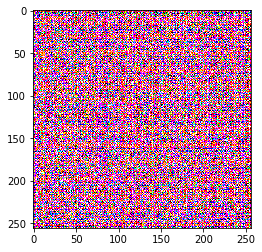

In [0]:
def Generator():
  inputs=tf.keras.layers.Input(shape=[None,None,3])
  down_stack=[
      downsample(64,apply_batchnorm=False), #(bs,128,128,64)
      downsample(128),                      #(bs,64,64,128)
      downsample(256),                      #(bs,32,32,256)
      downsample(512),                      #(bs,16,16,512)
      downsample(512),                      #(bs,8,8,512)
      downsample(512),                      #(bs,4,4,512)
      downsample(512),                      #(bs,2,2,512)
      downsample(512),                      #(bs,1,1,512)
  ]
  up_stack=[
      upsample(512,apply_dropout=True),     #(bs,2,2,1024)
      upsample(512,apply_dropout=True),     #(bs,4,4,1024)
      upsample(512,apply_dropout=True),     #(bs,8,8,1024)
      upsample(512),                        #(bs,16,16,1024)
      upsample(256),                        #(bs,32,32,512)
      upsample(128),                        #(bs,64,64,256)
      upsample(64)                          #(bs,128,128,128)
  ]
  
  initializer=tf.random_normal_initializer(0,0.2)
  last=Conv2DTranspose(filters=3,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    activation="tanh")
  x=inputs
  s=[]
  concat=Concatenate()
  for down in down_stack:
    x=down(x)
    s.append(x)
  s=reversed(s[:-1])
  for up,sk in zip(up_stack,s):
    x=up(x)
    x=concat([x,sk])
  last=last(x)
  return Model(inputs=inputs,outputs=last)
generator=Generator()
gen_output=generator(((inimg+1)*255),training=False)
plt.imshow(gen_output[0,...])

TensorShape([1, 16, 16, 1])

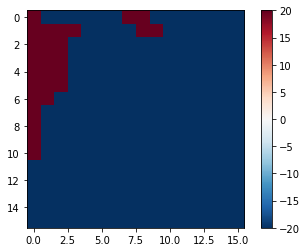

In [0]:
def Discriminator():
  ini=Input(shape=[None,None,3],name="input_img")
  gen=Input(shape=[None,None,3],name="gener_img")
  con=concatenate([ini,gen])
  initializer=tf.random_normal_initializer(0,0.2)
  down1=downsample(64,apply_batchnorm=False)(con)
  down2=downsample(128)(down1)
  down3=downsample(256)(down2)
  down4=downsample(512)(down3)
  last=tf.keras.layers.Conv2D(filters=1,
                             kernel_size=4,
                             strides=1,
                             kernel_initializer=initializer,
                             padding="same")(down4)
  return tf.keras.Model(inputs=[ini,gen],outputs=last)
discriminator=Discriminator()
dis_out=discriminator([((inimg+1)*255),gen_output],training=False)
plt.imshow(dis_out[0,...,-1],vmin=-20,vmax=20,cmap='RdBu_r')
plt.colorbar()
dis_out.shape


In [0]:
loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output,disc_generated_output):
  real_loss=loss_object(tf.ones_like(disc_real_output),disc_real_output)
  generated_loss=loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
  total_disc_loss=real_loss+generated_loss
  return total_disc_loss

In [0]:
LAMBDA=100
def generator_loss(disc_generated_output,gen_output,target):
  gan_loss=loss_object(tf.ones_like(disc_generated_output),disc_generated_output)
  
  l1_loss=tf.reduce_mean(tf.abs(target-gen_output))
  total_gen_loss=gan_loss+(LAMBDA*l1_loss)
  return total_gen_loss

In [0]:
import os
generator_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer=tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
checkpoint_prefix=os.path.join(CKPATH,"ckpt")
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                              discriminator_optimizer=discriminator_optimizer,
                              generator=generator,
                              discriminator=discriminator)
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [0]:
def generate_images(model,test_input,tar,save_filename=False,display_imgs=False):
  prediction=model(test_input,training=True)
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH+'/output/'+save_filename+'.jpg',prediction[0,...])
  '''plt.figure(figsize=(10,10))
  display_list=[test_input[0],tar[0],prediction[0]]
  title=['input image','ground truth','predict image']
  if display_imgs:
    for i in range(3):
      plt.subplot(1,3,i+1)
      plt.title(title[i])
      plt.imshow(display_list[i]*0.5+0.5)
      plt.axis('off')
  plt.show()'''

In [0]:
@tf.function
def train_step(input_image,target):
  with tf.GradientTape() as gen_tape,tf.GradientTape() as discr_tape:
    output_image=generator(input_image,training=True)
    output_gen_discr=discriminator([output_image,input_image],training=True)
    output_trg_discr=discriminator([target,input_image],training=True)
    discr_loss=discriminator_loss(output_trg_discr,output_gen_discr)
    gen_loss=generator_loss(output_gen_discr,output_image,target)
    generator_grads=gen_tape.gradient(gen_loss,generator.trainable_variables)
    discriminator_grads=discr_tape.gradient(discr_loss,discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads,discriminator.trainable_variables))

In [0]:
from IPython.display import clear_output
def train(dataset,epochs):
  for epoch in range(epochs):
    imgi=0
    for input_image,target in dataset:
      print('epoch'+str(epoch)+'- train:'+str(imgi)+'/'+str(len(tr_urls)))
      imgi+=1
      train_step(input_image,target)
      clear_output(wait=True)
    imgi=0
    for inp,tar in test_dataset.take(5):
      generate_images(generator,inp,tar,str(imgi)+'-'+str(epoch),display_imgs=True)
      imgi+=1
    if(epoch+1)%50==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [0]:
train(train_dataset,600)


epoch37- train:163/400
